## Preamble

In [1]:
%load_ext autoreload
%autoreload 0

In [2]:
%autoreload

In [3]:
import sys
sys.path.append('/pollard/home/bsmith/Projects/haplo-benchmark/include/StrainFacts')

In [4]:
import xarray as xr
import sqlite3
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import torch
import pyro
import scipy as sp

import lib.plot
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from lib.pandas_util import idxwhere


import sfacts as sf

# from lib.project_style import color_palette, major_allele_frequency_bins
# from lib.project_data import metagenotype_db_to_xarray
# from lib.plot import ordination_plot, mds_ordination, nmds_ordination
# import lib.plot
# from lib.plot import construct_ordered_pallete
# from lib.pandas_util import idxwhere

## Load Data

In [5]:
fit = sf.data.World.load('data/zshi.sp-102506.metagenotype.filt-poly05-cvrg25.fit-sfacts44-s200-g5000-seed0.refit-sfacts41-g10000-seed0.world.nc')
fit.data['position'] = fit.data.position.astype(int)
print(fit.sizes)


cull_threshold = 1e-3

fit_communities = fit.communities.mlift('sel', strain=fit.communities.max("sample") > cull_threshold)
print((1 - fit_communities.sum("strain")).max())
fit_communities = sf.Communities(fit_communities.data / fit_communities.sum("strain"))
fit_genotypes = fit.genotypes.mlift('sel', strain=fit_communities.strain)

fit = sf.World.from_combined(fit_communities, fit_genotypes, fit.metagenotypes)
print(fit.sizes)

Frozen(SortedKeysDict({'strain': 200, 'sample': 9232, 'position': 75942, 'allele': 2}))
<xarray.DataArray 'communities' ()>
array(0.00055164, dtype=float32)
Coordinates:
    species_id  int64 102506
Frozen(SortedKeysDict({'strain': 123, 'sample': 9232, 'position': 75942, 'allele': 2}))


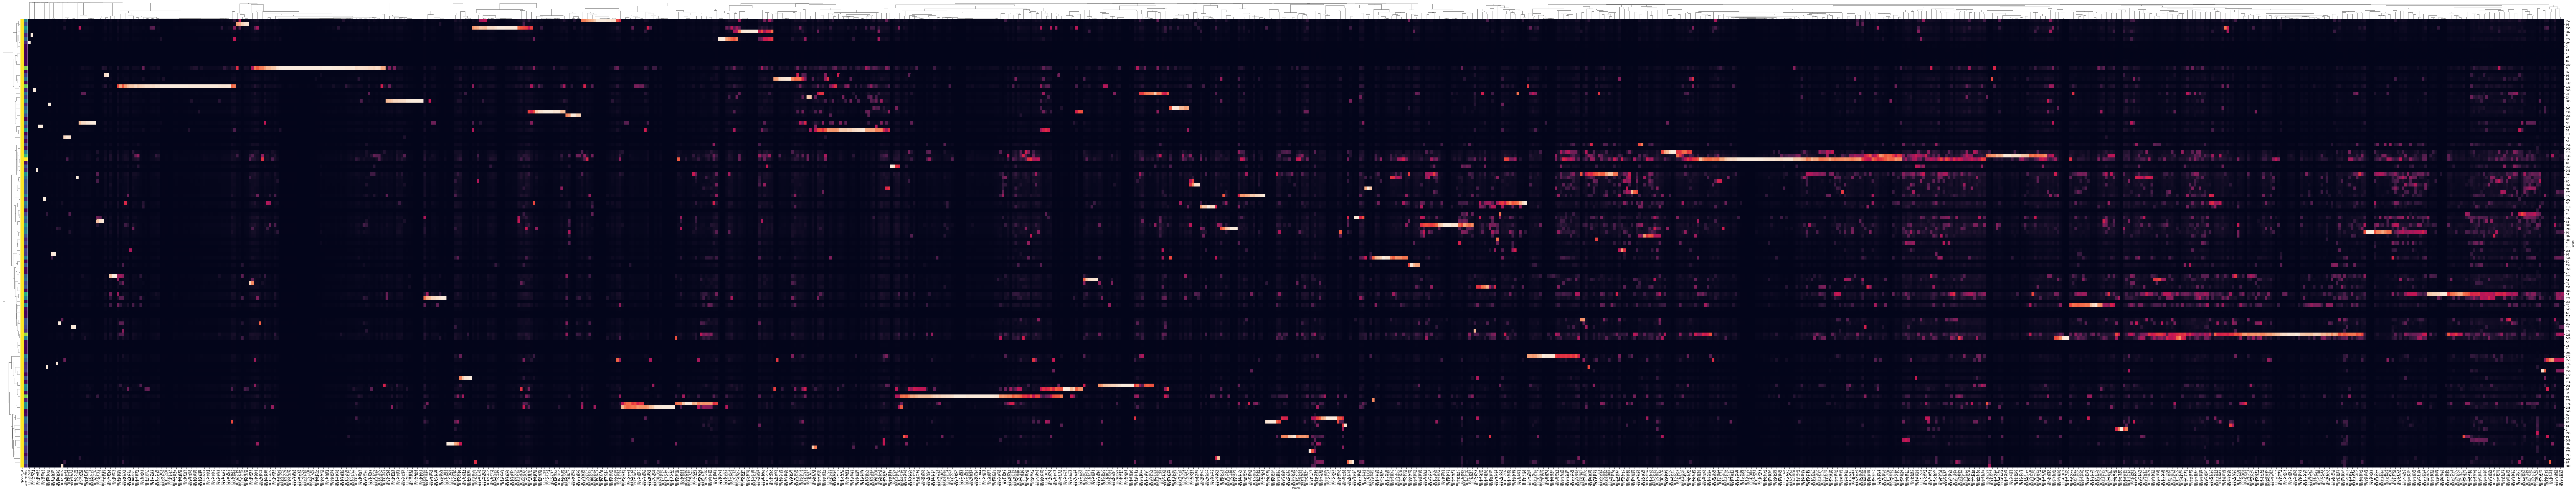

In [6]:
sf.plot_community(fit.random_sample(sample=1000), row_linkage_func=lambda w: w.genotypes.linkage("strain"))

In [7]:
ref = sf.data.Metagenotypes.load('data/gtprodb.sp-102506.genotype.nc')
ref = ref.mlift('sel', position=fit.position).to_estimated_genotypes(pseudo=0)
ref.sizes

Frozen({'strain': 1000, 'position': 75942})

/opt/conda/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log2
  result_data = func(*input_data)


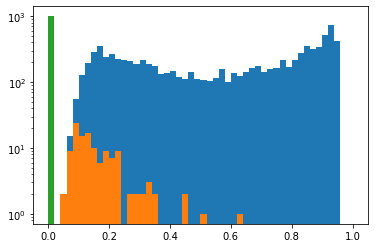

In [8]:
bins = np.linspace(0, 1, num=51)

plt.hist(fit.metagenotypes.to_estimated_genotypes(pseudo=1e-3).entropy(), bins=bins)
plt.hist(fit.genotypes.entropy(), bins=bins)
plt.hist(ref.entropy(), bins=bins)

plt.yscale('log')
None

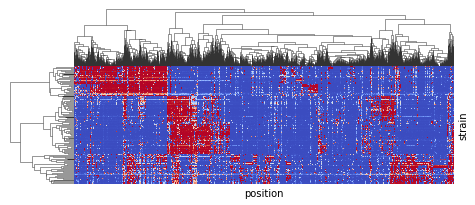

In [9]:
sf.plot.plot_genotype(fit.random_sample(position=5000), scaley=2e-2, scalex=1e-3, yticklabels=0)

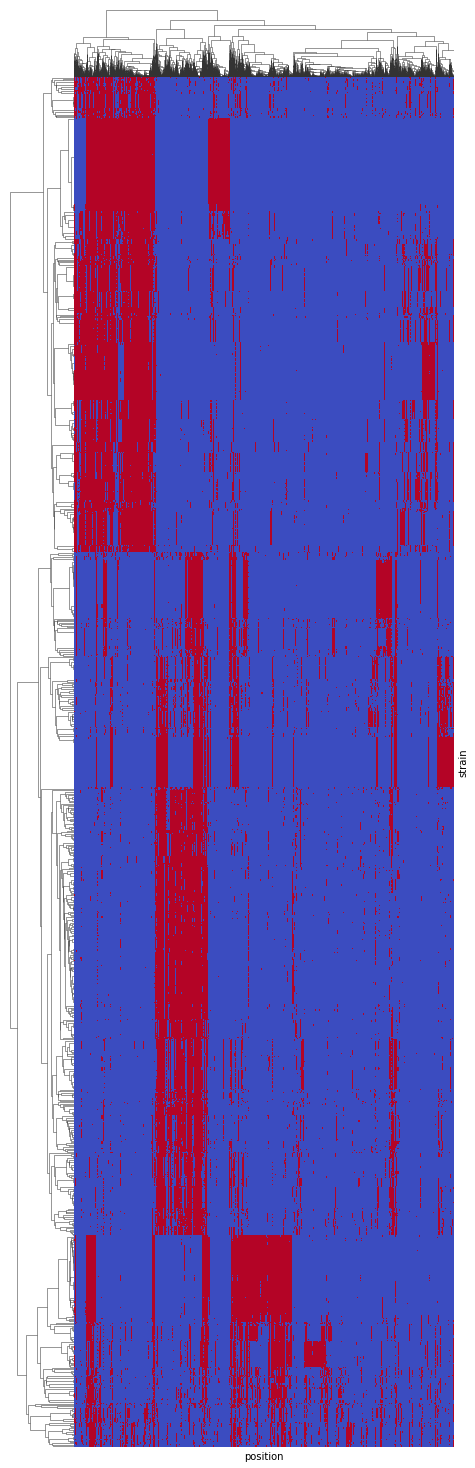

In [10]:
sf.plot.plot_genotype(ref.random_sample(position=5000), scaley=2e-2, scalex=1e-3, yticklabels=0)

In [11]:
genotype_entropy_thresh = 0.30

fit_genotypes_filt = fit.genotypes.mlift('sel', strain=fit.genotypes.entropy() < genotype_entropy_thresh)
fit_genotypes_highent = fit.genotypes.mlift('sel', strain=fit.genotypes.entropy() > genotype_entropy_thresh)

fit_genotypes_filt.sizes, fit_genotypes_highent.sizes

(Frozen({'strain': 112, 'position': 75942}),
 Frozen({'strain': 11, 'position': 75942}))

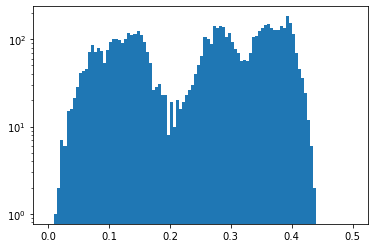

In [12]:
plt.hist(squareform(fit_genotypes_filt.pdist()), bins=np.linspace(0, 0.5, num=101))
plt.yscale('log')
None

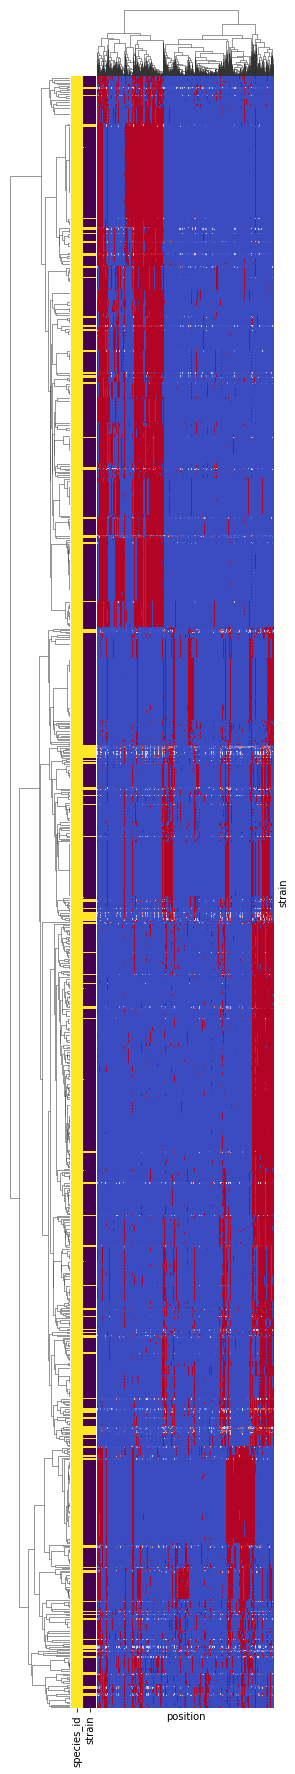

In [13]:
g = sf.data.Genotypes.concat(dict(
    ref=ref,
    fit=fit_genotypes_filt,
#     ent=fit_genotypes_highent,
), dim='strain')


sf.plot.plot_genotype(g.random_sample(position=2500), row_colors_func=lambda w: w.strain.str.startswith('fit'), scaley=2e-2, scalex=1e-3, yticklabels=0)

In [14]:
position_meta = pd.read_table(
    'ref/gtpro/variants_main.covered.hq.snp_dict.tsv',
    names=['species_id', 'position', 'contig', 'contig_position', 'ref', 'alt']
).set_index('position')[lambda x: x.species_id.isin([102506])]

position_meta

,species_id,contig,contig_position,ref,alt
position,,,,,
29904,102506,QFSG01000004,980,C,T
30035,102506,QFSG01000004,1111,T,A
30046,102506,QFSG01000004,1122,T,A
30048,102506,QFSG01000004,1124,G,A
30053,102506,QFSG01000004,1129,C,T
...,...,...,...,...,...
5712804,102506,QFSG01000485,5000,A,C
5712807,102506,QFSG01000485,5003,A,T
5712812,102506,QFSG01000485,5008,C,T


In [15]:
ref_diss = ref.pdist("strain")
ref_clust = AgglomerativeClustering(n_clusters=None, distance_threshold=0.02, affinity='precomputed', linkage='complete').fit_predict(ref_diss)
ref_clust = pd.Series(ref_clust, index=ref_diss.index)
ref_clust.value_counts()

14     67
141    37
95     34
130    32
7      28
       ..
191     1
193     1
195     1
196     1
310     1
Length: 311, dtype: int64

In [16]:
ref_agg = sf.data.Genotypes(
    ref.data.to_dataframe().join(ref_clust.rename("clust")).reset_index().groupby(["clust", "position"]).mean().rename_axis(index=dict(clust='strain')).squeeze().to_xarray()
)

In [17]:
ld = {}
for contig, pos in position_meta.loc[ref_agg.position].groupby('contig'):
    print(contig)
    g = ref_agg.sel(position=pos.index)
    r2 = (1 - pdist(g.values.T, 'correlation'))**2
    x = pdist(np.expand_dims(pos.contig_position.values, axis=1), 'cityblock')
    ld[contig] = (x, r2)
ref_ld = pd.DataFrame(np.concatenate([np.stack([x, r2], axis=1) for x, r2 in ld.values()]), columns=['x', 'r2'])

QFSG01000004
QFSG01000008
QFSG01000010
QFSG01000013
QFSG01000021
QFSG01000023
QFSG01000024
QFSG01000025
QFSG01000026
QFSG01000028
QFSG01000030
QFSG01000031
QFSG01000032
QFSG01000036
QFSG01000039
QFSG01000040
QFSG01000046
QFSG01000050
QFSG01000051
QFSG01000052
QFSG01000059
QFSG01000060
QFSG01000064
QFSG01000065
QFSG01000066
QFSG01000067
QFSG01000074
QFSG01000075
QFSG01000076
QFSG01000077
QFSG01000078
QFSG01000086
QFSG01000087
QFSG01000088
QFSG01000091
QFSG01000092
QFSG01000093
QFSG01000094
QFSG01000096
QFSG01000099
QFSG01000100
QFSG01000105
QFSG01000109
QFSG01000114
QFSG01000116
QFSG01000118
QFSG01000119
QFSG01000130
QFSG01000138
QFSG01000140
QFSG01000142
QFSG01000150
QFSG01000163
QFSG01000166
QFSG01000167
QFSG01000169
QFSG01000172
QFSG01000194
QFSG01000196
QFSG01000197
QFSG01000198
QFSG01000200
QFSG01000203
QFSG01000217
QFSG01000226
QFSG01000231
QFSG01000232
QFSG01000235
QFSG01000250
QFSG01000251
QFSG01000260
QFSG01000263
QFSG01000267
QFSG01000294
QFSG01000298
QFSG01000310
QFSG01000325

In [18]:
est_diss = fit_genotypes_filt.pdist("strain")
est_clust = AgglomerativeClustering(n_clusters=None, distance_threshold=0.02, affinity='precomputed', linkage='complete').fit_predict(est_diss)
est_clust = pd.Series(est_clust, index=est_diss.index)
est_clust.value_counts()

0      2
4      2
1      2
106    1
107    1
      ..
33     1
32     1
31     1
30     1
108    1
Length: 109, dtype: int64

In [19]:
est_agg = sf.data.Genotypes(
    fit_genotypes_filt.data.to_dataframe().join(est_clust.rename("clust")).reset_index().groupby(["clust", "position"]).mean().genotypes.rename_axis(index=dict(clust='strain')).to_xarray()
)

In [20]:
ld = {}
for contig, pos in position_meta.loc[est_agg.position].groupby('contig'):
    print(contig)
    g = est_agg.sel(position=pos.index)
    r2 = (1 - pdist(g.values.T, 'correlation'))**2
    x = pdist(np.expand_dims(pos.contig_position.values, axis=1), 'cityblock')
    ld[contig] = (x, r2)
est_ld = pd.DataFrame(np.concatenate([np.stack([x, r2], axis=1) for x, r2 in ld.values()]), columns=['x', 'r2'])

QFSG01000004
QFSG01000008
QFSG01000010
QFSG01000013
QFSG01000021
QFSG01000023
QFSG01000024
QFSG01000025
QFSG01000026
QFSG01000028
QFSG01000030
QFSG01000031
QFSG01000032
QFSG01000036
QFSG01000039
QFSG01000040
QFSG01000046
QFSG01000050
QFSG01000051
QFSG01000052
QFSG01000059
QFSG01000060
QFSG01000064
QFSG01000065
QFSG01000066
QFSG01000067
QFSG01000074
QFSG01000075
QFSG01000076
QFSG01000077
QFSG01000078
QFSG01000086
QFSG01000087
QFSG01000088
QFSG01000091
QFSG01000092
QFSG01000093
QFSG01000094
QFSG01000096
QFSG01000099
QFSG01000100
QFSG01000105
QFSG01000109
QFSG01000114
QFSG01000116
QFSG01000118
QFSG01000119
QFSG01000130
QFSG01000138
QFSG01000140
QFSG01000142
QFSG01000150
QFSG01000163
QFSG01000166
QFSG01000167
QFSG01000169
QFSG01000172
QFSG01000194
QFSG01000196
QFSG01000197
QFSG01000198
QFSG01000200
QFSG01000203
QFSG01000217
QFSG01000226
QFSG01000231
QFSG01000232
QFSG01000235
QFSG01000250
QFSG01000251
QFSG01000260
QFSG01000263
QFSG01000267
QFSG01000294
QFSG01000298
QFSG01000310
QFSG01000325

Text(0, 0.5, 'LD ($R^2$)')

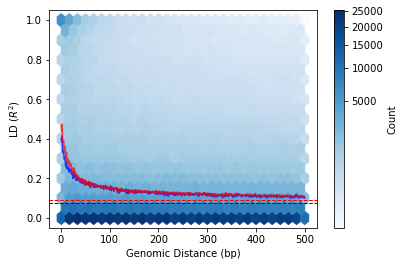

In [22]:
stepsize = 1
right = 500

d = est_ld[lambda p: p.x < right]
bins_est = {}
for start in range(0, right, stepsize):
    stop = start + stepsize
    bins_est[start] = d[(d.x >= start) & (d.x < stop)].r2.mean()
    
    
d = ref_ld[lambda p: p.x < right]
bins_ref = {}
for start in range(0, right, stepsize):
    stop = start + stepsize
    bins_ref[start] = d[(d.x >= start) & (d.x < stop)].r2.mean()


fig = plt.figure()

plt.hexbin('x', 'r2', data=d, cmap='Blues', norm=mpl.colors.PowerNorm(1/3), mincnt=1, gridsize=(30, 10), label='__nolegend__')
plt.colorbar(label='Count')

ax = plt.gca()

ax.plot(pd.Series(bins_ref), color='blue', label=f'reference genotypes', alpha=0.7)
ax.plot(pd.Series(bins_est), color='red', label=f'inferred genotypes', alpha=0.7)

ax.axhline(est_ld.r2.mean(), lw=1, color='red', linestyle='--')
ax.axhline(ref_ld.r2.mean(), lw=1, color='blue', linestyle='--')

# ax.legend(title=f'Mean LD at pairwise distance')  #bbox_to_anchor=(0.85, 1.15), ncol=2)

ax.set_xlabel('Genomic Distance (bp)')
ax.set_ylabel('LD ($R^2$)')